# Regression with deep learning
## Goals
* Normalize data feature-wise
* Perform linear regression with R to establish a baseline
* Build a simple input-output model, that hopefully will be similar in performance (look at interpretation)
* Add hidden layers to the network, such that more complexity can be modeled
* Establish a training-validation-test loop (mention k-fold cross validation, but do not implement it)
* Study the effect of different optimizers and their hyperparameters, as well as batch size and network complexity on convergence

**USE SGD AND SIGMOIDS**

## First part
* We provide simple model in Keras
* Add single hidden layer to improve performance and try to get performance lower than 3.2. Only adjust the number of epochs


## Second part
* Exercise: try to get test performance under 2.5
* Try different optimizers and investigate the properties of the loss curves
* Try different learning rates (orders of magnitude)
* Final exercise: some other regression data set with performance threshold

In [1]:
library(keras)
library(tidyverse)
library(plyr)
library(tidyr)
library(rsample)

# Plotting
library(ggplot2)
library(repr)
options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact



In [2]:
data <- dataset_boston_housing()

In [3]:
glimpse(data)

List of 2
 $ train:List of 2
  ..$ x: num [1:404, 1:13] 1.2325 0.0218 4.8982 0.0396 3.6931 ...
  ..$ y: num [1:404(1d)] 15.2 42.3 50 21.1 17.7 18.5 11.3 15.6 15.6 14.4 ...
 $ test :List of 2
  ..$ x: num [1:102, 1:13] 18.0846 0.1233 0.055 1.2735 0.0715 ...
  ..$ y: num [1:102(1d)] 7.2 18.8 19 27 22.2 24.5 31.2 22.9 20.5 23.2 ...


The data set consists of 13 features, and one target.

CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per $10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's

In [4]:
c(c(X_train, y_train), c(X_test, y_test)) %<-% data 

## Normalize
## TODO: turn into exercise with `apply`

In [5]:
X_mean <- apply(X_train, 2, mean)
X_sd <- apply(X_train, 2, sd)

In [6]:
X_train <- scale(X_train, center = X_mean, scale = X_sd)
X_test  <- scale(X_test, center = X_mean, scale = X_sd)

In [7]:
class(dim(X_train)[2])

[1] "integer"

# Linear regression with baseline

In [8]:
df <- cbind(data.frame(X_train), data.frame(y_train))
head(df)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,y_train
-0.27190919,-0.4830166,-0.4352220,-0.2565147,-0.1650220,-0.1762241,0.8120550,0.1165538,-0.6254735,-0.5944330,1.1470781,0.4475222,0.8241983,15.2
-0.40292691,2.9880792,-1.3322597,-0.2565147,-1.2136770,1.8920002,-1.9079948,1.2460402,-0.8554019,-0.3480010,-1.7160613,0.4313711,-1.3275563,42.3
0.12478548,-0.4830166,1.0270523,-0.2565147,0.6278635,-1.8274222,1.1091131,-1.1859686,1.6738104,1.5633491,0.7835049,0.2203441,-1.3068796,50.0
-0.40099633,-0.4830166,-0.8683253,-0.2565147,-0.3611120,-0.3241557,-1.2351404,1.1058088,-0.5105093,-1.0933074,0.7835049,0.4475222,-0.6521177,21.1
-0.00562732,-0.4830166,1.0270523,-0.2565147,1.3269669,0.1534520,0.6939476,-0.5778555,1.6738104,1.5633491,0.7835049,0.3893995,0.2631706,17.7
-0.37455796,-0.4830166,-0.5468011,-0.2565147,-0.5486763,-0.7876746,0.1893067,0.4831160,-0.5105093,-0.7146437,0.5108249,0.3862118,-0.1379572,18.5


In [9]:
df <- df %>% rename(c(
    X1 = 'crim',
    X2 = 'zn',
    X3 = 'indus',
    X4 = 'chas',
    X5 = 'nox',
    X6 = 'rm',
    X7 = 'age',
    X8 = 'dis',
    X9 = 'rad',
    X10 = 'tax',
    X11 = 'ptratio',
    X12 = 'b',
    X13 = 'lstat',
    y_train = 'medv'
))
head(df)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
-0.27190919,-0.4830166,-0.4352220,-0.2565147,-0.1650220,-0.1762241,0.8120550,0.1165538,-0.6254735,-0.5944330,1.1470781,0.4475222,0.8241983,15.2
-0.40292691,2.9880792,-1.3322597,-0.2565147,-1.2136770,1.8920002,-1.9079948,1.2460402,-0.8554019,-0.3480010,-1.7160613,0.4313711,-1.3275563,42.3
0.12478548,-0.4830166,1.0270523,-0.2565147,0.6278635,-1.8274222,1.1091131,-1.1859686,1.6738104,1.5633491,0.7835049,0.2203441,-1.3068796,50.0
-0.40099633,-0.4830166,-0.8683253,-0.2565147,-0.3611120,-0.3241557,-1.2351404,1.1058088,-0.5105093,-1.0933074,0.7835049,0.4475222,-0.6521177,21.1
-0.00562732,-0.4830166,1.0270523,-0.2565147,1.3269669,0.1534520,0.6939476,-0.5778555,1.6738104,1.5633491,0.7835049,0.3893995,0.2631706,17.7
-0.37455796,-0.4830166,-0.5468011,-0.2565147,-0.5486763,-0.7876746,0.1893067,0.4831160,-0.5105093,-0.7146437,0.5108249,0.3862118,-0.1379572,18.5


In [10]:
res <- lm(medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat, data=df)
res


Call:
lm(formula = medv ~ crim + zn + indus + chas + nox + rm + age + 
    dis + rad + tax + ptratio + b + lstat, data = df)

Coefficients:
(Intercept)         crim           zn        indus         chas          nox  
   22.39505     -1.10887      1.35477      0.02713      0.99559     -2.40454  
         rm          age          dis          rad          tax      ptratio  
    2.39926      0.21146     -3.47552      2.91175     -1.95985     -1.98544  
          b        lstat  
    0.82057     -4.03238  


In [108]:
rss <- c(crossprod(res$residuals))
mse <- rss / length(res$residuals)
mse

[1] 22.0048

## Split training set into training and validation set

In [12]:
split_at <- 0.8 * dim(X_train)[1]
X_val <- X_train[-(1:split_at),]
y_val <- y_train[-(1:split_at)]
X_train <- X_train[1:split_at,]
y_train <- y_train[1:split_at]

In [13]:
glimpse(X_train)

 num [1:323, 1:13] -0.27191 -0.40293 0.12479 -0.401 -0.00563 ...


In [14]:
glimpse(X_val)

 num [1:81, 1:13] -0.00724 -0.38238 -0.27287 -0.33713 -0.40059 ...


## Build a very simple network: input to output, without hidden layers

In [55]:
model <- keras_model_sequential() %>%
    layer_dense(units = 1, input_shape=dim(X_train)[2])

model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.1),
    loss = "mse",
    metrics = c("mae")
)
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_25 (Dense)                    (None, 1)                       14          
Total params: 14
Trainable params: 14
Non-trainable params: 0
________________________________________________________________________________


In [56]:
num_epochs <- 50

history <- model %>% fit(
    X_train, y_train,
    validation_data = list(X_val, y_val),
    epochs = num_epochs, batch_size = 16, verbose = 1
)

# history <- data.frame(
#     epoch = seq(1, num_epochs),
#     validation = history$metrics$val_loss,
#     training = history$metrics$loss
# #         validation = history$metrics$val_mean_absolute_error,
# #         training = history$metrics$mean_absolute_error
# ) #%>% gather("set", "mae", c("training", "validation"))

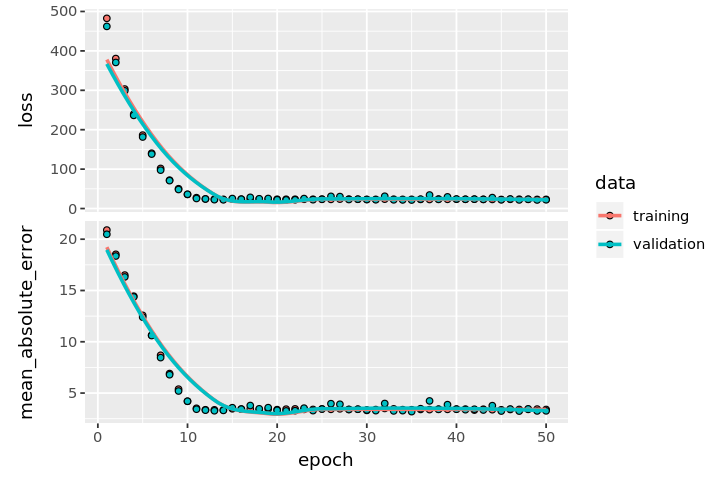

In [57]:
plot(history)

In [58]:
model %>% evaluate(X_test, y_test)

$loss
[1] 29.7772

$mean_absolute_error
[1] 3.925372

## Compare coefficients of linear model and Keras model

In [33]:
data.frame(keras=get_weights(model)[[1]], lm=res$coeff[-1]) 

,keras,lm
crim,-1.3490804,-1.10886514
zn,1.3922449,1.35476736
indus,-0.4441627,0.02713486
chas,0.7594306,0.99558642
nox,-2.0104954,-2.40454334
rm,1.9456625,2.39925892
age,0.5383388,0.21145707
dis,-3.3231192,-3.47552033
rad,2.6695626,2.91175474
tax,-1.8922937,-1.95984594


## Improve model by adding a hidden layer

In [123]:
num_epochs <- 500

model <- keras_model_sequential() %>%
    layer_dense(units = 128, activation = "relu", input_shape = dim(X_train)[2]) %>%
   layer_dense(units = 256, activation = "relu") %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_rmsprop(lr = 0.01),
#     optimizer = optimizer_adamax(lr = 1),
#     optimizer = optimizer_sgd(lr = 0.01),
#     optimizer = optimizer_rmsprop(lr = 0.01),
    loss = "mse",
    metrics = c("mae")
)

history <- model %>% fit(
    X_train, y_train,
    validation_data = list(X_val, y_val),
    epochs = num_epochs, batch_size = 16, verbose = 1
)

# performance <- data.frame(
#     epoch = seq(1, num_epochs),
# #     validation = history$metrics$val_loss,
# #     training = history$metrics$loss
#     validation = history$metrics$val_mean_absolute_error,
#     training = history$metrics$mean_absolute_error
# ) %>% gather("set", "mae", c("training", "validation"))

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_95 (Dense)                    (None, 128)                     1792        
________________________________________________________________________________
dense_96 (Dense)                    (None, 256)                     33024       
________________________________________________________________________________
dense_97 (Dense)                    (None, 512)                     131584      
________________________________________________________________________________
dense_98 (Dense)                    (None, 1)                       513         
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
________________________________________________________________________________


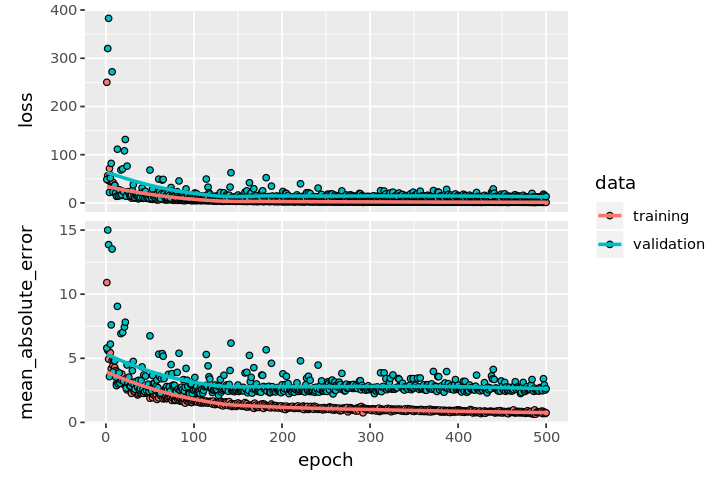

In [124]:
plot(history)

In [125]:
model %>% evaluate(X_test, y_test)

$loss
[1] 15.42981

$mean_absolute_error
[1] 2.722969

## Cut notebook here

## Play around with the different optimizers
* What's the effect on convergence swapping optimizers with the same learning rate?
  * ADAM and RMSProp converge relatively quickly, AdaMax later. SGD show steepest decline for smaller learning rates, but fluctuates more for bigger learning rates.
* What's the effect on convergence decreasing or increasing the batch size? Try to divide or multiply the batch size by two each time.
* idem for adding additional layers
* What happens if the learning rate is too big?
* What happens to the training and validation loss and mean absolute error when you use thousands of epochs?